# 1. Import Packages & Load Soft Labels

In [1]:
import os

os.environ["HF_HOME"] = "/home/shared/.cache/huggingface"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/home/shared/.cache/huggingface/hub"

In [2]:
import json
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from datasets import Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    default_data_collator
)
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pickle

In [3]:
# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


In [4]:
from huggingface_hub import login
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("hf_token")
login(token=hf_token)

# 2. Load Student Model

In [5]:
# ✅ Step 1: Load PubMedBERT tokenizer and model with manual BERT specification

new_train = True # Set to True if you want to train a new model

if new_train:
    from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

    # student_model_id = "michiyasunaga/BioLinkBERT-base"
    student_model_id = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"

    config = BertConfig.from_pretrained(student_model_id)
    config.num_labels = 3
    config.model_type = "bert" 

    student_tokenizer = BertTokenizer.from_pretrained(student_model_id)
    student_model = BertForSequenceClassification.from_pretrained(student_model_id, config=config)
else:
    # ✅ Step 2: Load the pre-trained student model and tokenizer
    student_model_path = "/home/shared/models/student_distilled"
    student_tokenizer = BertTokenizer.from_pretrained(student_model_path)
    student_model = BertForSequenceClassification.from_pretrained(student_model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3. Data Preprocessing

## 3.1 Convert Soft Labels to HF Dataset and Tokenize

In [6]:
# ✅ Step 2: Load soft labels from file
with open("soft_labels_T1.5.json", "r") as f:
    soft_dataset = json.load(f)

In [7]:
# ✅ Step 3: Convert soft dataset to HF Dataset and tokenize
hf_dataset = Dataset.from_list(soft_dataset)

def tokenize_function(example):
    tokens = student_tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["soft_labels_t"] = torch.tensor(example["soft_label"], dtype=torch.float)
    # ✅ Add input length field
    tokens["input_length"] = len(student_tokenizer.tokenize(example["input_text"]))
    return tokens

tokenized_dataset = hf_dataset.map(tokenize_function, remove_columns=["input_text", "soft_label"])
tokenized_dataset_copy = tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 3.2 Drop Rows with Input Length > 512 Tokens

In [8]:
# Drop examples with input length greater than 512
tokenized_dataset = tokenized_dataset.filter(lambda example: example["input_length"] <= 512)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
test_tokenized_dataset = tokenized_dataset.to_pandas()
test_tokenized_dataset.shape

(974, 6)

In [10]:
test_copy = tokenized_dataset_copy.to_pandas()
test_copy["gold_index"].value_counts()

gold_index
2    552
0    338
1    110
Name: count, dtype: int64

In [11]:
test_tokenized_dataset["gold_index"].value_counts()

gold_index
2    536
0    332
1    106
Name: count, dtype: int64

In [12]:
test_copy.query('input_length > 512').sort_values ('input_length')["gold_index"].value_counts()

gold_index
2    16
0     6
1     4
Name: count, dtype: int64

In [13]:
test_tokenized_dataset.query('input_length > 512').sort_values ('input_length')

,gold_index,input_ids,token_type_ids,attention_mask,soft_labels_t,input_length


## 3.3 Check the variance of soft labels

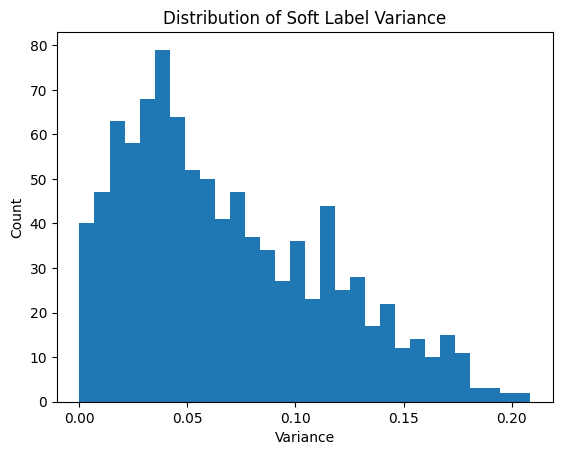

In [14]:
test_tokenized_dataset["soft_labels_t"][0]
soft_label_variances = test_tokenized_dataset["soft_labels_t"].apply(lambda x: np.var(x))

# Check out the distribution of soft label variances
import matplotlib.pyplot as plt
plt.hist(soft_label_variances, bins=30)
plt.title("Distribution of Soft Label Variance")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.show()

## 3.4 Train Test Split

In [15]:
# ✅ Step 3.5: Split tokenized dataset into train/validation
from sklearn.model_selection import train_test_split

# Convert to list of dictionaries
tokenized_list = tokenized_dataset.to_list()

# Split the list into train and validation
train_list, val_list = train_test_split(tokenized_list, test_size=0.5, random_state=401)

# Convert back to HuggingFace Datasets
from datasets import Dataset
train_dataset = Dataset.from_list(train_list)
val_dataset = Dataset.from_list(val_list)

In [16]:
# ✅ Step 4: Build DataLoaders
train_loader = DataLoader(
    train_dataset,  # ✅ Use the split train set
    batch_size=16,
    shuffle=True,
    collate_fn=default_data_collator
)

val_loader = DataLoader(
    val_dataset,    # ✅ Use the split val set (optional for evaluation)
    batch_size=16,
    shuffle=False,
    collate_fn=default_data_collator
)

In [17]:
train_loader.dataset[0].keys()

dict_keys(['gold_index', 'input_ids', 'token_type_ids', 'attention_mask', 'soft_labels_t', 'input_length'])

# 4. Train Student Model

## 4.1 Training Configurations

In [18]:
# ✅ Step 5: Training config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)

optimizer = AdamW(student_model.parameters(), lr=1e-5)

loss_fn_kl = torch.nn.KLDivLoss(reduction="batchmean")
loss_fn_ce = torch.nn.CrossEntropyLoss()

In [19]:
student_model.parameters()

<generator object Module.parameters at 0x7f85d06c19a0>

In [20]:

# ✅ Step 5.9 Initialize validation metrics
train_losses = []
val_losses = []
val_ce_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

epochs = 50
best_val_loss = 100
best_accuracy = 0
patience = 30
counter = 0
alpha = 0.5 # alpha * KL + (1 - alpha) * CE
loss_tolerance = 0.02 # Save model if new accuracy is better and new loss is within this tolerance
acc_margin = 0.005 # Save model if new accuracy is better than the best accuracy by this margin

In [ ]:
# Reload previous metrics if they exist
if (new_train == False):
    with open("/home/shared/models/student_distilled_metrics/distill_metrics.pkl", "rb") as f:
        metrics = pickle.load(f)

    train_losses = metrics["train_losses"]
    val_losses = metrics["val_losses"]
    val_ce_losses = metrics["val_ce_losses"]
    val_accuracies = metrics["val_accuracies"]
    val_precisions = metrics["val_precisions"]
    val_recalls = metrics["val_recalls"]
    val_f1_scores = metrics["val_f1_scores"]
    best_val_loss = metrics["best_val_loss"]       # load best loss
    best_accuracy = metrics["best_accuracy"]       # load best acc

    print(f"📊 Resumed training history. Best val loss: {best_val_loss:.4f}, Best accuracy: {best_accuracy:.4f}")
    epoch = len(val_losses)
else:
    print("📊 Starting new training session.")

📊 Starting new training session.


## 4.2 Training Loop

In [ ]:
counter = 0
# ✅ Step 6: Distillation training loop
for epoch in range(epochs):
    student_model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        soft_labels = batch["soft_labels_t"].to(device)
        hard_labels = batch["gold_index"].to(device)
        
        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        loss = alpha * loss_fn_kl(log_probs, soft_labels) + (1 - alpha) * loss_fn_ce(logits, hard_labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # For plotting
     
    student_model.eval()
    correct = 0
    total = 0
    val_loss = 0
    val_ce_loss_total = 0  # ✅ New: Only For Tracking CrossEntropy Loss
    all_predictions = []
    all_hard_labels = []

    # ✅ Step 6.1: Validation loop
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            soft_labels = batch["soft_labels_t"].to(device)
            hard_labels = batch["gold_index"].to(device)

            logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            loss = alpha * loss_fn_kl(log_probs, soft_labels) + (1 - alpha) * loss_fn_ce(logits, hard_labels)
            val_loss += loss.item()
            
             # ✅ New: Only calcualte the cross-entropy validation loss for comparison
            ce_loss = loss_fn_ce(logits, hard_labels)
            val_ce_loss_total += ce_loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == hard_labels).sum().item()
            total += soft_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_hard_labels.extend(hard_labels.cpu().numpy())
            
    sum_0=np.sum(np.array(all_predictions)==0)
    sum_1=np.sum(np.array(all_predictions)==1)
    sum_2=np.sum(np.array(all_predictions)==2)
    print(f"Predictions: {sum_0}x0s, {sum_1}x1s, {sum_2}x2s")
    
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_ce_loss = val_ce_loss_total / len(val_loader)  # ✅ New: Track Only Average CrossEntropy Loss
    val_losses.append(avg_val_loss) # for plotting
    val_ce_losses.append(avg_val_ce_loss)  # ✅ New: for plotting
    
    accuracy = correct / total
    val_accuracies.append(accuracy)

    # Calculate additional metrics
    precision = precision_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    
    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
    f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    # ✅ New: Print Only Average CrossEntropy Loss
    print(f"           └ Val CE-only Loss (for gold-only comparison): {avg_val_ce_loss:.4f}")
    
    # Early Stopping
    # Save only when acc >= 0.65
    # and new accuracy is better than the best accuracy by acc_margin
    # and new loss is within loss_tolerance of the best loss
    if (accuracy >= 0.65 and accuracy - best_accuracy >= acc_margin and avg_val_loss - best_val_loss <= loss_tolerance):
        counter = 0
        best_val_loss = avg_val_loss
        best_accuracy = accuracy
        print("New best val_loss:", best_val_loss, "New best accuracy:", best_accuracy)
        # Save the best model
        output_dir = "/home/shared/models/student_distilled"
        student_model.save_pretrained(output_dir)
        student_tokenizer.save_pretrained(output_dir)
        print("Best model saved!")
    
    if avg_val_loss >= best_val_loss and accuracy < best_accuracy:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

KeyboardInterrupt: 

## 4.3 Save after Training

In [24]:
# Save training metrics
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_ce_losses": val_ce_losses,  # ✅ New: Save CrossEntropy Losses
    "val_accuracies": val_accuracies,
    "val_precisions": val_precisions,
    "val_recalls": val_recalls,
    "val_f1_scores": val_f1_scores,
    "best_val_loss": best_val_loss,
    "best_accuracy": best_accuracy,
}

with open("/home/shared/models/student_distilled_metrics/distill_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("✅ Training metrics saved.")

✅ Training metrics saved.


In [45]:
# Save the distilled model
output_dir = "/home/shared/models/student_distilled"
student_model.save_pretrained(output_dir)
student_tokenizer.save_pretrained(output_dir)

('/home/shared/models/student_distilled/tokenizer_config.json',
 '/home/shared/models/student_distilled/special_tokens_map.json',
 '/home/shared/models/student_distilled/vocab.txt',
 '/home/shared/models/student_distilled/added_tokens.json')

In [21]:
loss_fn_ce(log_probs, hard_labels)

tensor(0.4875, device='cuda:0')

In [22]:
loss_fn_kl(log_probs, soft_labels)

tensor(2.6540, device='cuda:0')

In [23]:
logits

tensor([[-0.0405, -2.1733,  1.5279],
        [-1.4430, -1.6155,  3.3812],
        [ 0.3815, -1.9838,  1.7691],
        [-0.7437, -0.9880,  2.1216]], device='cuda:0')

In [24]:
log_probs

tensor([[-1.7780, -3.9107, -0.2095],
        [-4.8389, -5.0114, -0.0147],
        [-1.6290, -3.9944, -0.2415],
        [-2.9621, -3.2064, -0.0967]], device='cuda:0')

In [25]:
# Test the structure of the output of the student model
with torch.no_grad():
    student_logits = student_model(**inputs)
    
student_logits

NameError: name 'inputs' is not defined

In [26]:
# Get the token ID for "]"
token_id = student_tokenizer.convert_tokens_to_ids("Maybe")
print(f"Token ID for 'Maybe': {token_id}")

Token ID for 'Maybe': 1


In [29]:
preds

tensor([2, 2, 2, 2, 0, 2, 2, 0], device='cuda:0')

# 5. Plotting

In [28]:
import matplotlib.pyplot as plt

In [29]:
epochs = list(range(1, len(val_losses) + 1))  # Epoch numbers

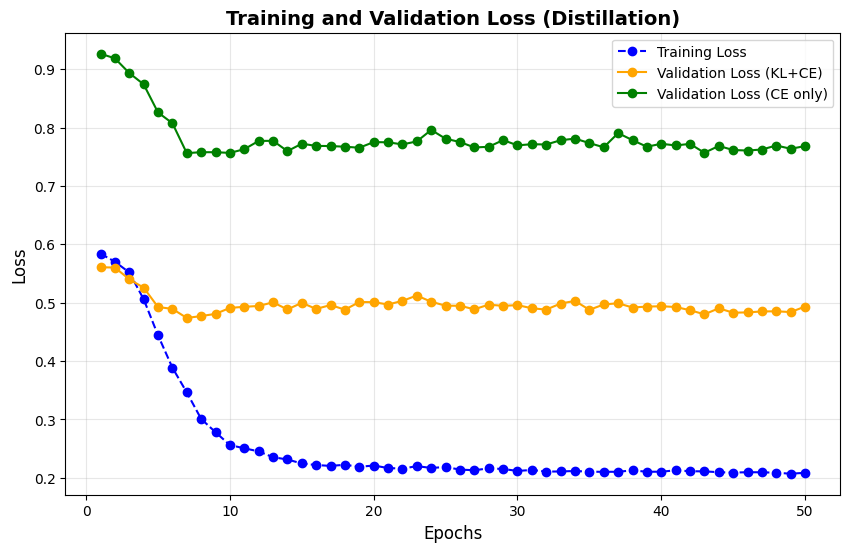

In [34]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss (KL+CE)", marker="o", linestyle="-", color="orange")
plt.plot(epochs, val_ce_losses, label="Validation Loss (CE only)", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss (Distillation)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

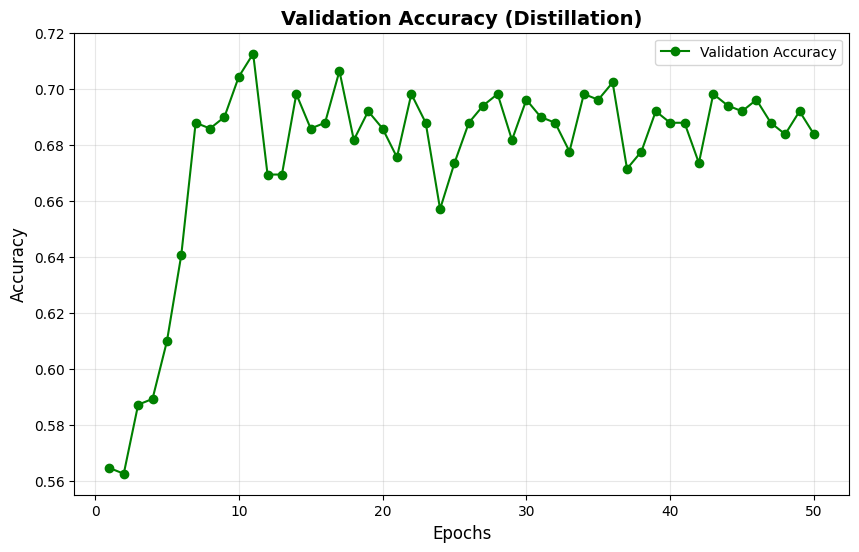

In [35]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy (Distillation)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

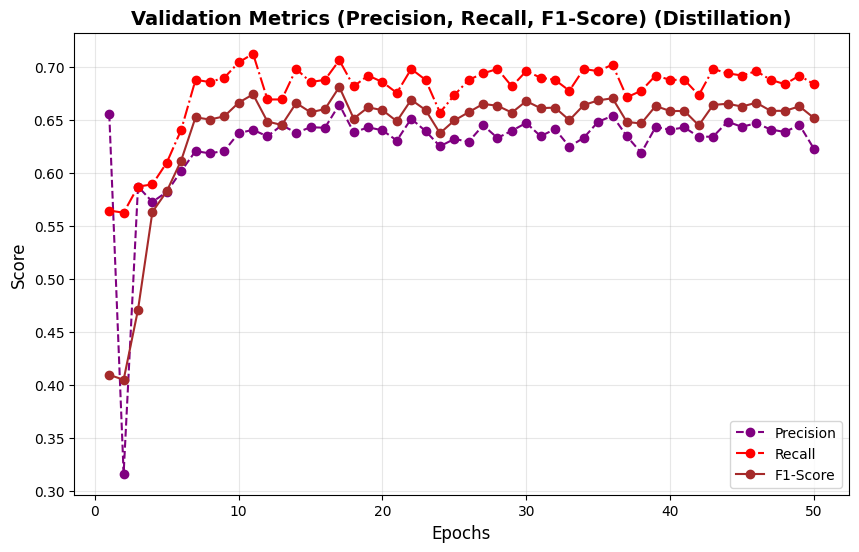

In [36]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precisions, label="Precision", marker="o", linestyle="--", color="purple")
plt.plot(epochs, val_recalls, label="Recall", marker="o", linestyle="-.", color="red")
plt.plot(epochs, val_f1_scores, label="F1-Score", marker="o", linestyle="-", color="brown")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics (Precision, Recall, F1-Score) (Distillation)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()